In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sklearn
import scipy as scp
import openpyxl
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sktime as skt

# supress this warning
pd.options.mode.chained_assignment = None

print({pkg.__name__:pkg.__version__ for pkg in [pd, np, scp, sklearn, openpyxl, sns, matplotlib, skt]})

{'pandas': '1.3.5', 'numpy': '1.24.3', 'scipy': '1.8.1', 'sklearn': '1.1.1', 'openpyxl': '3.0.10', 'seaborn': '0.11.2', 'matplotlib': '3.5.2', 'sktime': '0.29.1'}


In [3]:
#importing sys
import sys
  
# adding src to the system path
sys.path.insert(0, '../src')


### Initial look at the data

#### i) load data

In [4]:
from ml_pipeline.dataset import load_excel
DATA_PATH = '../input/elevator_failure_prediction.xlsx'

# this creates a dict of excel sheets
xl_dict = load_excel(DATA_PATH)
xl_dict.keys()

dict_keys(['data'])

In [5]:
# get the relevant sheet
raw = xl_dict['data']
raw

,Time,Temperature,Humidity,RPM,Vibrations,Pressure,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,Sensor6,Status
0,2020-01-01 00:00:00,31.11716,74.1715,72.0,16.81,76.0,0.791225,203.793426,0.582975,799.101683,7.149643,15.842287,0.0
1,2020-01-01 00:01:00,31.11716,74.1715,72.0,16.81,76.0,0.791225,203.793426,0.582975,799.101683,7.149643,15.842287,0.0
2,2020-01-01 00:02:00,32.08894,74.0803,72.0,17.08,76.0,0.803988,204.411886,0.575500,834.897700,7.089729,15.739743,0.0
3,2020-01-01 00:03:00,31.67221,73.9272,72.0,15.79,76.0,0.743260,204.363994,0.575500,805.467950,7.135375,15.731202,0.0
4,2020-01-01 00:04:00,31.95202,73.7603,72.0,16.84,76.0,0.792391,203.947834,0.584042,822.142650,7.092582,15.773928,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44635,2020-01-31 23:55:00,33.52116,0.0000,72.0,23.00,11.0,1.082305,17.777731,0.372634,73.096240,7.115405,16.115723,0.0
44636,2020-01-31 23:56:00,33.17696,0.0000,72.0,23.38,11.0,1.100088,17.769158,0.361957,71.922282,7.123963,16.098630,0.0
44637,2020-01-31 23:57:00,32.88938,0.0000,72.0,24.77,11.0,1.165494,17.822902,0.352347,67.741018,7.103994,16.115723,0.0
44638,2020-01-31 23:58:00,33.11005,0.0000,72.0,24.82,11.0,1.167873,17.769206,0.332061,63.904680,7.123963,16.021731,0.0


#### ii) data overview

In [6]:
# initial look at the columns
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44640 entries, 0 to 44639
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Time         44640 non-null  datetime64[ns]
 1   Temperature  44631 non-null  float64       
 2   Humidity     44640 non-null  float64       
 3   RPM          44640 non-null  float64       
 4   Vibrations   44640 non-null  float64       
 5   Pressure     44640 non-null  float64       
 6   Sensor1      44640 non-null  float64       
 7   Sensor2      40586 non-null  float64       
 8   Sensor3      44640 non-null  float64       
 9   Sensor4      44640 non-null  float64       
 10  Sensor5      44640 non-null  float64       
 11  Sensor6      44640 non-null  float64       
 12  Status       44640 non-null  float64       
dtypes: datetime64[ns](1), float64(12)
memory usage: 4.4 MB


In [7]:
# look at an example row
raw.iloc[1000]

Time           2020-01-01 16:40:00
Temperature               38.60568
Humidity                   73.9486
RPM                           72.0
Vibrations                   13.01
Pressure                      76.0
Sensor1                   0.612267
Sensor2                 204.218814
Sensor3                   0.959879
Sensor4                  825.31645
Sensor5                   7.121112
Sensor6                  15.697017
Status                         0.0
Name: 1000, dtype: object

#### iii) examine Target

In [8]:
# examine target variable, tt is a very imbalanced dataset
raw.Status.value_counts().sort_index()

0.0    40584
1.0        2
2.0     4054
Name: Status, dtype: int64

#### iv) Examine time

In [9]:
# check if there are any missing time points 
raw.Time.iloc[[0,-1]]

0       2020-01-01 00:00:00
44639   2020-01-31 23:59:00
Name: Time, dtype: datetime64[ns]

In [10]:
# method 1) check number of rows is as expected
# total number of minutes = days * (hours per day) * (minutes per hour) 
31 * 24 * 60 == len(raw)

True

In [11]:
# method 2) check interval between each row is always the same
# see intervals between indices
raw.Time.diff()[1:].unique()

array([60000000000], dtype='timedelta64[ns]')

In [12]:
# this number is in billionths of a second, we divied by 1 billion to confirm it is 60 seconds
60000000000 / 1e9

60.0

In [13]:
# set time as index
raw.set_index('Time', inplace=True)

### Train/Test split


In [14]:
from ml_pipeline.dataset import time_train_test_split
from ml_pipeline.diagnosis import check_target_split, check_number_of_full_days

#### i) Make train/test split

In [15]:
# make split 
train, test = time_train_test_split(raw, proportion = 0.8)

#### ii) Check target distribution 

In [16]:
# check distribution of our target in the split, it is not good
check_target_split(train, test, target='Status')

            train    test
Status                   
Normal      31656  8928.0
Broke           2     NaN
Recovering   4054     NaN


In [17]:
# make another split 
train, test = time_train_test_split(raw, proportion = 0.5)

# check distribution of our target in the split, it looks good
check_target_split(train, test, target='Status')

            train   test
Status                  
Normal      21375  19209
Broke           1      1
Recovering    944   3110


#### iii) Check day distribution

In [18]:

check_number_of_full_days(train.index)

Mon      2.0
Tues     2.0
Wed      3.0
Thurs    2.5
Fri      2.0
Sat      2.0
Sun      2.0
Name: Time, dtype: float64


In [19]:
# make another split
train, test = time_train_test_split(raw, proportion = 14/31)

# check target split again
check_target_split(train, test, target='Status')

# check day split again
print('-'*40)
check_number_of_full_days(train.index)

            train   test
Status                  
Normal      19215  21369
Broke           1      1
Recovering    944   3110
----------------------------------------
Mon      2.0
Tues     2.0
Wed      2.0
Thurs    2.0
Fri      2.0
Sat      2.0
Sun      2.0
Name: Time, dtype: float64


In [20]:
# save files
train.to_csv('../input/train/data.csv')
test.to_csv('../input/test/data.csv')

### Constructing training set: window size and lag 

In [21]:
from sktime.forecasting.model_selection import SlidingWindowSplitter

In [22]:
# this splitter also uses window of 1 hour of data, but now we predict 5 minutes after the end of the window
splitter_60_future = SlidingWindowSplitter(window_length = 60, step_length = 1, fh = 5, start_with_window = True)

split = splitter_60_future.split(raw.index)

# we can see the ground truth index is 5 after end of our input window
next(split)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59], dtype=int64),
 array([64], dtype=int64))

In [23]:
print(next(split))
print(next(split))

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60], dtype=int64), array([65], dtype=int64))
(array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61], dtype=int64), array([66], dtype=int64))


In [24]:
# this splitter means each prediction uses window of 1 hour of data, to predict final minute of that window
splitter_60_present = SlidingWindowSplitter(window_length = 60, step_length = 1, fh = 0)

# now the ground truth index is at end of input window
next(splitter_60_present.split(raw.index))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59], dtype=int64),
 array([59], dtype=int64))

In [25]:
# we can also look at alternatively with a smaller window
splitter_30_present = SlidingWindowSplitter(window_length = 30, step_length = 1, fh = 0)

# because we have a smaller window we can now predict for index 29, which we couldn't before
# this splitter results in 30 more training data points than the previous ones, because 60-30=30
next(splitter_30_present.split(raw.index))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int64),
 array([29], dtype=int64))

In [26]:
# rough figure to visualise the difference beteen these options
fig, ax = plt.subplots(figsize=(15,5), )

ax.plot(np.arange(30,60), np.repeat(1,30), marker='x',  color='b')
ax.scatter([59], [1], marker='o', color='r',)

ax.plot(np.arange(60), np.repeat(2,60), marker='x', color='b')
ax.scatter([59], [2], marker='o', color='r')

ax.plot(np.arange(60), np.repeat(3,60), marker='x', color='b', label='Feature set')
ax.scatter([6``         `4], [3], marker='o', color='r', label='Ground truth')

ax.legend()

ax.set_yticks([1,2,3])
ax.set_yticklabels(['Window=30, Lag=0', 'Window=60, Lag=0','Window=60, Lag=5',])
ax.set_ylim(0,4)
ax.set_xlabel('Time index')

SyntaxError: invalid syntax (3072955657.py, line 11)

In [ ]:
# function to create our training set
from ml_pipeline.dataset import create_windows
X, y = create_windows(raw.iloc[:100])



In [ ]:
# check it has worked for one example
y[5]

Time
2020-01-01 00:34:00    0.0
Name: Status, dtype: float64

In [27]:
X[5]
X.shape

NameError: name 'X' is not defined

In [ ]:
1. x[5] numpy flatten

### Pandas methods for time series

#### pd.DataFrame.diff

In [ ]:
raw.iloc[:4,:4]

,Temperature,Humidity,RPM,Vibrations
Time,,,,
2020-01-01 00:00:00,31.11716,74.1715,72.0,16.81
2020-01-01 00:01:00,31.11716,74.1715,72.0,16.81
2020-01-01 00:02:00,32.08894,74.0803,72.0,17.08
2020-01-01 00:03:00,31.67221,73.9272,72.0,15.79


In [ ]:
raw.diff(periods=1, axis=0).iloc[:4,:4]

,Temperature,Humidity,RPM,Vibrations
Time,,,,
2020-01-01 00:00:00,NaN,NaN,NaN,NaN
2020-01-01 00:01:00,0.00000,0.0000,0.0,0.00
2020-01-01 00:02:00,0.97178,-0.0912,0.0,0.27
2020-01-01 00:03:00,-0.41673,-0.1531,0.0,-1.29


#### pd.DataFrame.interpolate

In [ ]:
raw.Temperature.iloc[:10]

Time
2020-01-01 00:00:00    31.11716
2020-01-01 00:01:00    31.11716
2020-01-01 00:02:00    32.08894
2020-01-01 00:03:00    31.67221
2020-01-01 00:04:00    31.95202
2020-01-01 00:05:00    32.23816
2020-01-01 00:06:00    32.00982
2020-01-01 00:07:00    31.88320
2020-01-01 00:08:00    32.09234
2020-01-01 00:09:00    32.25679
Name: Temperature, dtype: float64

In [ ]:
ts_raw = raw.Temperature.iloc[:10].copy()
ts_nulls = ts_raw.copy()
ts_nulls.iloc[3:7] = np.nan

In [ ]:
ts_nulls

Time
2020-01-01 00:00:00    31.11716
2020-01-01 00:01:00    31.11716
2020-01-01 00:02:00    32.08894
2020-01-01 00:03:00         NaN
2020-01-01 00:04:00         NaN
2020-01-01 00:05:00         NaN
2020-01-01 00:06:00         NaN
2020-01-01 00:07:00    31.88320
2020-01-01 00:08:00    32.09234
2020-01-01 00:09:00    32.25679
Name: Temperature, dtype: float64

<AxesSubplot:xlabel='Time'>

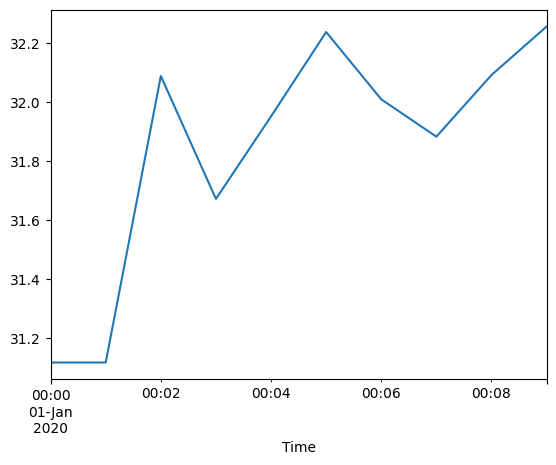

In [ ]:
ts_raw.plot()

<AxesSubplot:xlabel='Time'>

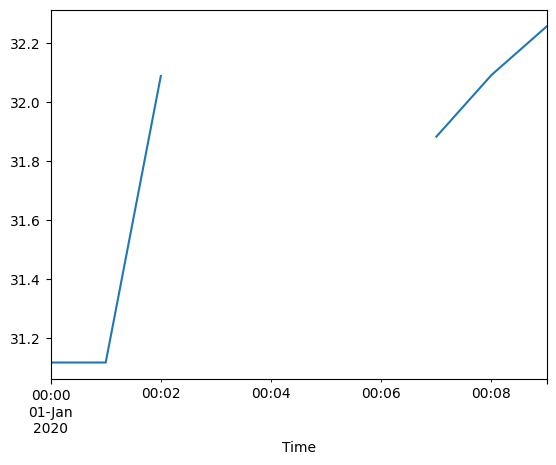

In [ ]:
ts_nulls.interpolate(method='bfill', limit=2, limit_area='outside').plot()

#### datetime index

In [ ]:
df = pd.DataFrame(data=[[0,1,2]])
type(df.index)

pandas.core.indexes.range.RangeIndex

In [ ]:
i = df.index[0]
type(i)

int

In [ ]:
i

0

In [ ]:
type(raw.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [ ]:
t = raw.index[0]
type(t)

pandas._libs.tslibs.timestamps.Timestamp

In [ ]:
t

Timestamp('2020-01-01 00:00:00')

In [ ]:
t.hour

0

In [ ]:
raw.index + pd.DateOffset(hours=1, minutes=1, months=1)

DatetimeIndex(['2020-02-01 01:01:00', '2020-02-01 01:02:00',
               '2020-02-01 01:03:00', '2020-02-01 01:04:00',
               '2020-02-01 01:05:00', '2020-02-01 01:06:00',
               '2020-02-01 01:07:00', '2020-02-01 01:08:00',
               '2020-02-01 01:09:00', '2020-02-01 01:10:00',
               ...
               '2020-03-01 00:51:00', '2020-03-01 00:52:00',
               '2020-03-01 00:53:00', '2020-03-01 00:54:00',
               '2020-03-01 00:55:00', '2020-03-01 00:56:00',
               '2020-03-01 00:57:00', '2020-03-01 00:58:00',
               '2020-03-01 00:59:00', '2020-03-01 01:00:00'],
              dtype='datetime64[ns]', name='Time', length=44640, freq=None)

In [ ]:
pd.date_range(
            start= t, 
            end = t + pd.DateOffset(hours=0, minutes=1),  
            freq='s')

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 00:00:01',
               '2020-01-01 00:00:02', '2020-01-01 00:00:03',
               '2020-01-01 00:00:04', '2020-01-01 00:00:05',
               '2020-01-01 00:00:06', '2020-01-01 00:00:07',
               '2020-01-01 00:00:08', '2020-01-01 00:00:09',
               '2020-01-01 00:00:10', '2020-01-01 00:00:11',
               '2020-01-01 00:00:12', '2020-01-01 00:00:13',
               '2020-01-01 00:00:14', '2020-01-01 00:00:15',
               '2020-01-01 00:00:16', '2020-01-01 00:00:17',
               '2020-01-01 00:00:18', '2020-01-01 00:00:19',
               '2020-01-01 00:00:20', '2020-01-01 00:00:21',
               '2020-01-01 00:00:22', '2020-01-01 00:00:23',
               '2020-01-01 00:00:24', '2020-01-01 00:00:25',
               '2020-01-01 00:00:26', '2020-01-01 00:00:27',
               '2020-01-01 00:00:28', '2020-01-01 00:00:29',
               '2020-01-01 00:00:30', '2020-01-01 00:00:31',
               '2020-01-

In [ ]:
pd.DataFrame(index=pd.date_range(start= t, 
            end = t + pd.DateOffset(hours=0, minutes=1), 
            freq='s', 
            ), columns =['sensors1'])

,sensors1
2020-01-01 00:00:00,NaN
2020-01-01 00:00:01,NaN
2020-01-01 00:00:02,NaN
2020-01-01 00:00:03,NaN
2020-01-01 00:00:04,NaN
...,...
2020-01-01 00:00:56,NaN
2020-01-01 00:00:57,NaN
2020-01-01 00:00:58,NaN
2020-01-01 00:00:59,NaN


### Plotting objects

In [ ]:
ts_raw

Time
2020-01-01 00:00:00    31.11716
2020-01-01 00:01:00    31.11716
2020-01-01 00:02:00    32.08894
2020-01-01 00:03:00    31.67221
2020-01-01 00:04:00    31.95202
2020-01-01 00:05:00    32.23816
2020-01-01 00:06:00    32.00982
2020-01-01 00:07:00    31.88320
2020-01-01 00:08:00    32.09234
2020-01-01 00:09:00    32.25679
Name: Temperature, dtype: float64

Plot using matplotlib figure

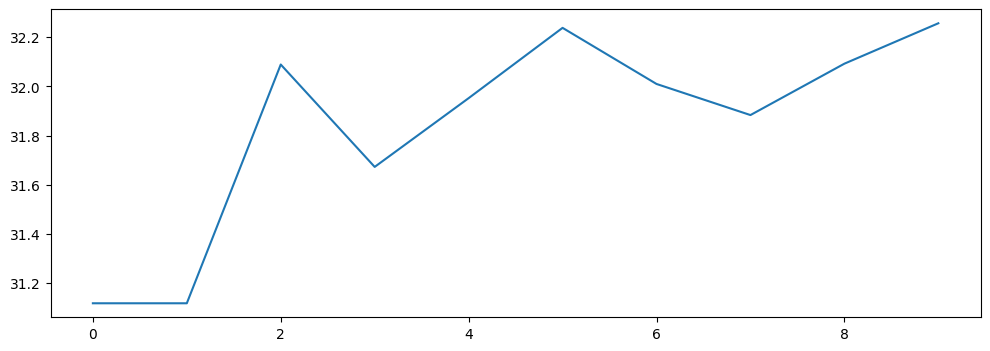

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(ts_raw.values)

In [ ]:
type(fig), type(ax)

(matplotlib.figure.Figure, matplotlib.axes._subplots.AxesSubplot)

In [ ]:
type(ax.figure)

matplotlib.figure.Figure

In [ ]:
ax.figure == fig

True

In [ ]:
fig.axes

[<AxesSubplot:>]

In [ ]:
fig.axes[0] == ax

True

Plotting without making a figure

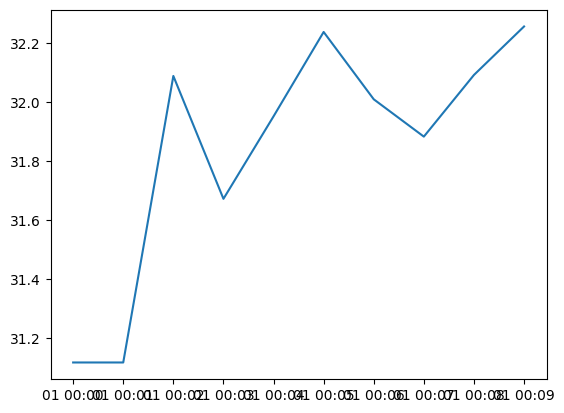

In [ ]:
X = plt.plot(ts_raw)[0]

In [ ]:
X

In [ ]:
type(X)

matplotlib.lines.Line2D

In [ ]:
X.axes

<AxesSubplot:>

In [ ]:
type(X.axes.figure)

matplotlib.figure.Figure

Plotting with seaborn

In [ ]:
import seaborn as sns

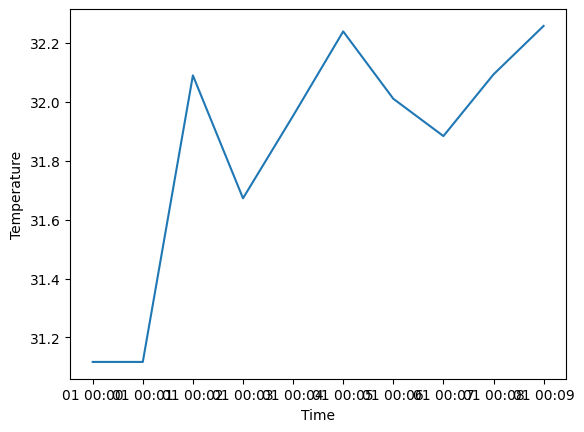

In [ ]:
X = sns.lineplot(data=ts_raw)

In [ ]:
type(X)

matplotlib.axes._subplots.AxesSubplot

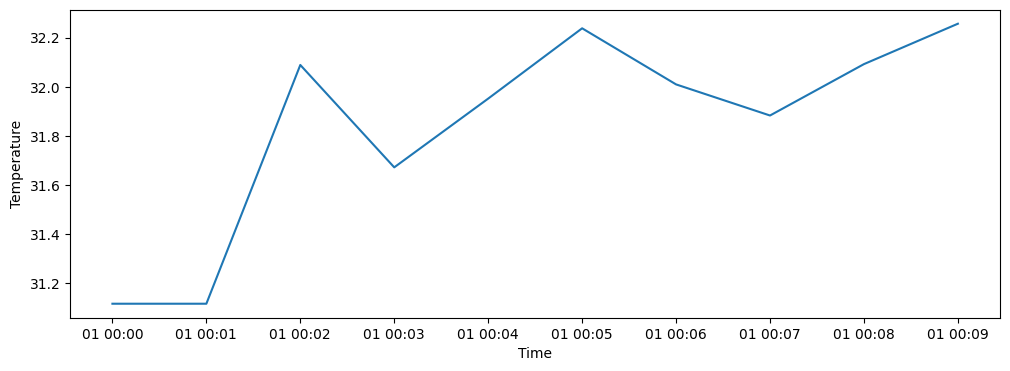

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
X = sns.lineplot(data=ts_raw, ax=ax)

In [ ]:
X

<AxesSubplot:xlabel='Time', ylabel='Temperature'>

Subplots

array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

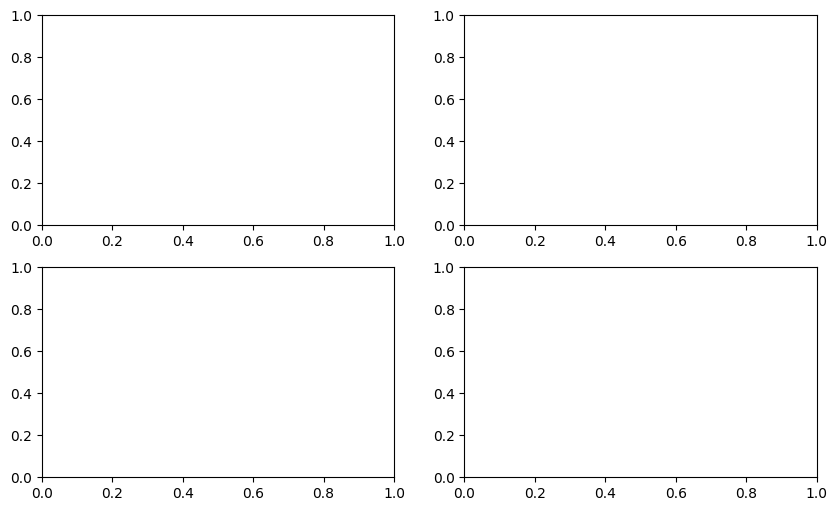

In [ ]:
fig, axes = plt.subplots(figsize=(10,6), ncols=2, nrows=2)
axes

<AxesSubplot:xlabel='Time', ylabel='Temperature'>

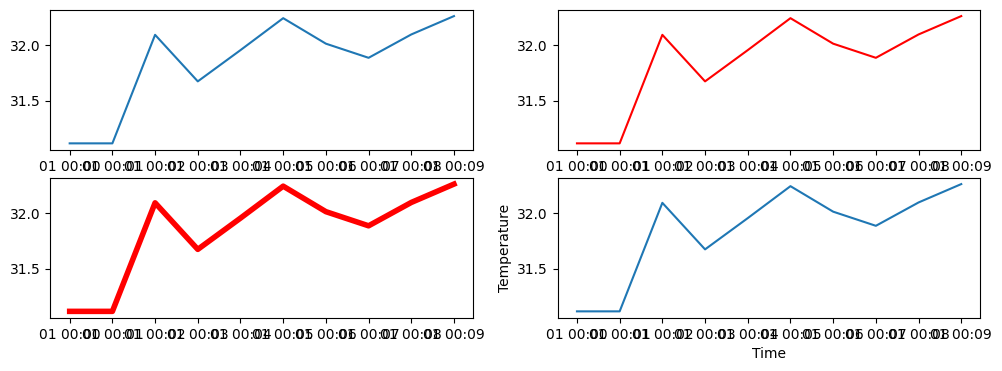

In [ ]:
fig, axes = plt.subplots(figsize=(12,4), ncols=2, nrows=2)

axes[0][0].plot(ts_raw)

axes[0][1].plot(ts_raw, color='r')

axes[1][0].plot(ts_raw, linewidth=4, color='r')

sns.lineplot(data=ts_raw, ax=axes[1,1])